## Credit Risk Modeling and Simulation

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as scs
import math

In [2]:
Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')


======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [3]:
# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

In [4]:
# Calculating Losses for Out of samples
Losses_out = np.zeros((Nout,K))
for s in range(Nout):
    # Random variable for for idosync 
    z3 = np.random.normal(0,1)
    
    # Random variable for systemic component
    x3 = np.random.normal(0,1,50) 
    
    # Based on generated correlated random number, credit worthiness index are calculated
    y3 = np.dot(sqrt_rho,x3)
    yjk3 = [y3[i-1] for i in driver.astype(int)]
    w3 = beta*yjk3 + (np.sqrt(1-beta**2))*z3
    
    # Calculated out-of-sample losses (100000 x 100) based on w from exposure values
    for j in range(K):
        Losses_out[s][j] = exposure[j][np.searchsorted(CS_Bdry[j],w3[j])]

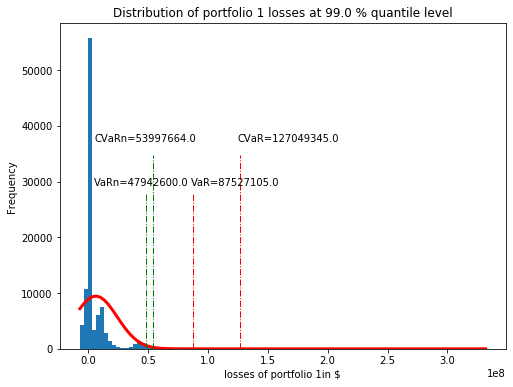

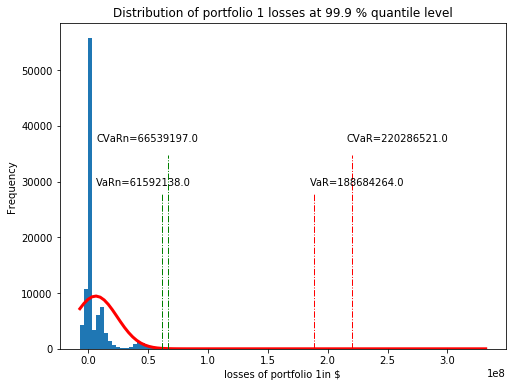

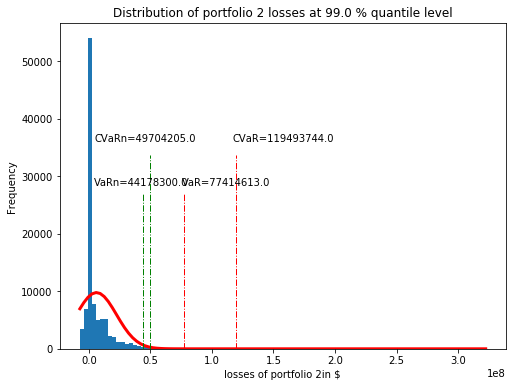

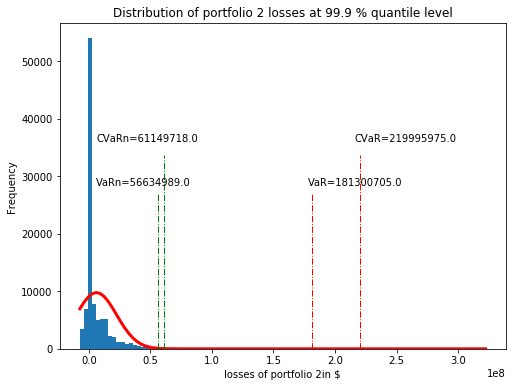

In [5]:
'''100000 samples are generated and true approximate distribution of losses is computed based on 
strong law of large numbers. Later, the values of VAR and CVAR for normal approximation are also 
computed and compared against VAR and CVAR of original distribution that has fat tail. Plots showing
the under estimation of tail risk by normal approximation are displayed'''

# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out, rowvar=False) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

# Initializing target variables to store output
VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))
l_out= np.zeros((Nout, len(x0)))

# Iterating over 2 portfolios
for portN in range(2):
    # Iterating over 2 alpha values
    for q in range(alphas.size):
        alf = alphas[q]
        
        # Calculating portfolio losses and VAR,CVAR from original approximation
        l_out[:,portN] = np.sort((np.dot(Losses_out,x0[portN])))
        VaRout[portN, q] = l_out[:,portN][int(math.ceil(len(l_out[:,portN]) * alf)) - 1]
        CVaRout[portN, q] = (1 / (len(l_out[:,portN]) * (1 - alf))) * ((math.ceil(len(l_out[:,portN]) * alf) - len(l_out[:,portN]) * alf) * VaRout[portN, q] + sum(l_out[:,portN][int(math.ceil(len(l_out[:,portN]) * alf)):]))
       
        # Calculating portfolio losses and VAR,CVAR from normal approximation
        VaRinN[portN, q] = np.mean(l_out[:,portN]) + scs.norm.ppf(alf) * np.std(l_out[:,portN])
        CVaRinN[portN, q] = np.mean(l_out[:,portN]) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(l_out[:,portN])
        
        # Plot a histogram of the distribution of losses
        plt.figure(figsize=(8,6))
        frequencyCounts1, binLocations1, patches1 = plt.hist(l_out[:,portN], 100)
        
        # Plotting the normal distribution approximation
        normf1 = (1 / (np.std(l_out[:,portN]) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations1.astype(float) - np.mean(l_out[:,portN])) / np.std(l_out[:,portN])) ** 2)
        normf1 = normf1 * sum(frequencyCounts1) / sum(normf1)
        plt.plot(binLocations1, normf1, color='r', linewidth=3.0)
        
        # Annotating the VAR,CVAR from original and normal approximation
        plt.plot([VaRinN[portN, q], VaRinN[portN, q]], [0, max(frequencyCounts1) / 2], color='g', linewidth=1, linestyle='-.')
        plt.plot([VaRout[portN, q], VaRout[portN, q]], [0, max(frequencyCounts1)/2], color='r', linewidth=1, linestyle='-.')
        plt.plot([CVaRout[portN, q], CVaRout[portN, q]], [0, max(frequencyCounts1)/1.6], color='r', linewidth=1, linestyle='-.')
        plt.plot([CVaRinN[portN, q], CVaRinN[portN, q]], [0, max(frequencyCounts1)/1.6], color='g', linewidth=1, linestyle='-.')
        
        plt.text(0.98 * VaRout[portN, q], max(frequencyCounts1) / 1.9, 'VaR='+str(np.round(VaRout[portN, q])))
        plt.text(0.98 * CVaRout[portN, q], max(frequencyCounts1) / 1.5, 'CVaR='+str(np.round(CVaRout[portN, q])))
        plt.text(0.1 * VaRinN[portN, q], max(frequencyCounts1) / 1.9, 'VaRn='+str(np.round(VaRinN[portN, q])))
        plt.text(0.1 * CVaRinN[portN, q], max(frequencyCounts1) / 1.5, 'CVaRn='+str(np.round(CVaRinN[portN, q])))
        
        # Labeling the axes and plot
        plt.title('Distribution of portfolio '+str(portN+1)+' losses at '+str(alf*100)+' % quantile level')
        plt.xlabel('losses of portfolio '+str(portN+1)+'in $')
        plt.ylabel('Frequency')
        plt.show()

In [6]:
# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

# Initializing target variables to store output
for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)

portf_loss_inMC1_tr = []
portf_loss_inMC2_tr = []
for tr in range(N_trials):
    
    # Monte Carlo approximation 1
    Losses_inMC1 = np.zeros((Nin,K))
    
    # systemic scenarios
    for s in range(np.int(np.ceil(Nin / Ns))): 
        x2 = np.random.normal(0,1,50)
        y2 = np.dot(sqrt_rho,x2)
        yjk2 = [y2[i-1] for i in driver.astype(int)]
        
        # idiosyncratic scenarios for each systemic
        for si in range(Ns): 
            z2 = np.random.normal(0,1)
            
            # Computing credit worthiness factor
            w2 = beta*yjk2 + (np.sqrt(1-beta**2))*z2
            
            # Calculated in-sample losses (1000 x 5 x (100 assets)) based on w from exposure values
            for a in range(K):
                Losses_inMC1[5*s+si][a] = exposure[a][np.searchsorted(CS_Bdry[a],w2[a])]

    # Monte Carlo approximation 2
    Losses_inMC2 = np.zeros((Nin,K))
    
    # systemic scenarios (1 idiosyncratic scenario for each systemic)
    for s in range(Nin): 
        x1 = np.random.normal(0,1,50)
        y1 = np.dot(sqrt_rho,x1)
        yjk1 = [y1[i-1] for i in driver.astype(int)]
        z1 = np.random.normal(0,1)
        
        # Computing credit worthiness factor
        w1 = beta*yjk1 + (np.sqrt(1-beta**2))*z1
        
        # Calculated losses for MC2 approximation (5000 x 1 x (100 assets))
        for a in range(K):
                Losses_inMC2[s][a] = exposure[a][np.searchsorted(CS_Bdry[a],w1[a])]
    
    # Computing portfolio Losses
    portf_loss_inMC1 = np.zeros((Nin,2))
    portf_loss_inMC2 = np.zeros((Nin,2))
    
    for portN in range(2):
        portf_loss_inMC1[:,portN] = p_loss_inMC1 = np.sort(np.dot(Losses_inMC1,x0[portN]))
        portf_loss_inMC2[:,portN] = p_loss_inMC2 = np.sort(np.dot(Losses_inMC2,x0[portN]))
        
        # computing mean and variance of individual assets
        mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
        var_MC1 = np.cov(Losses_inMC1, rowvar=False)
        mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
        var_MC2 = np.cov(Losses_inMC2, rowvar=False)
        
        # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
        mu_p_MC1 = np.mean(p_loss_inMC1)
        sigma_p_MC1 = np.std(p_loss_inMC1)
        mu_p_MC2 = np.mean(p_loss_inMC2)
        
        # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
        sigma_p_MC2 = np.std(p_loss_inMC2)
        
        for q in range(alphas.size):
            
            alf = alphas[q]
            
            N1 = len(p_loss_inMC1)
            N2 = len(p_loss_inMC2)
            
            # Compute VaR and CVaR for the current trial for MC1 and MC2 from sampling distribution
            VaRinMC1[portN, q][tr] = p_loss_inMC1[int(math.ceil(N1 * alf)) - 1]
            VaRinMC2[portN, q][tr] = p_loss_inMC2[int(math.ceil(N2 * alf)) - 1]
            CVaRinMC1[portN, q][tr] = (1 / (N1 * (1 - alf))) * ((math.ceil(N1 * alf) - N1 * alf) * VaRinMC1[portN, q][tr] + sum(p_loss_inMC1[int(math.ceil(N1 * alf)):]))
            CVaRinMC2[portN, q][tr] = (1 / (N2 * (1 - alf))) * ((math.ceil(N2 * alf) - N2 * alf) * VaRinMC2[portN, q][tr] + sum(p_loss_inMC2[int(math.ceil(N2 * alf)):]))
           
            # Compute VaR and CVaR for the current trial for MC1 and MC2 from normal distribution
            VaRinN1[portN, q][tr] =  mu_p_MC1 + scs.norm.ppf(alf) * sigma_p_MC1
            VaRinN2[portN, q][tr] =  mu_p_MC2 + scs.norm.ppf(alf) * sigma_p_MC2
            CVaRinN1[portN, q][tr] =  mu_p_MC1 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * sigma_p_MC1
            CVaRinN2[portN, q][tr] =  mu_p_MC2 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * sigma_p_MC2
            
    portf_loss_inMC1_tr.append(portf_loss_inMC1)
    portf_loss_inMC2_tr.append(portf_loss_inMC2)

In [7]:
# Display VaR and CVaR
for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('Out-of-sample N: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))


Portfolio 1:

Out-of-sample: VaR 99.0% = $87527105.24, CVaR 99.0% = $127049344.94
In-sample MC1: VaR 99.0% = $86484657.27, CVaR 99.0% = $127289418.36
In-sample MC2: VaR 99.0% = $88081642.62, CVaR 99.0% = $129689038.92
Out-of-sample N: VaR 99.0% = $47942600.01, CVaR 99.0% = $53997664.12
In-sample N1: VaR 99.0% = $47928608.30, CVaR 99.0% = $53988706.05
In-sample N2: VaR 99.0% = $48660137.73, CVaR 99.0% = $54813816.30

Out-of-sample: VaR 99.9% = $188684264.10, CVaR 99.9% = $220286520.58
In-sample MC1: VaR 99.9% = $180458572.54, CVaR 99.9% = $219321208.65
In-sample MC2: VaR 99.9% = $184711213.71, CVaR 99.9% = $223406836.48
Out-of-sample N: VaR 99.9% = $61592138.41, CVaR 99.9% = $66539196.65
In-sample N1: VaR 99.9% = $61589493.70, CVaR 99.9% = $66540664.49
In-sample N2: VaR 99.9% = $62531976.32, CVaR 99.9% = $67559603.72


Portfolio 2:

Out-of-sample: VaR 99.0% = $77414612.81, CVaR 99.0% = $119493744.43
In-sample MC1: VaR 99.0% = $76880393.47, CVaR 99.0% = $119637243.34
In-sample MC2: VaR 

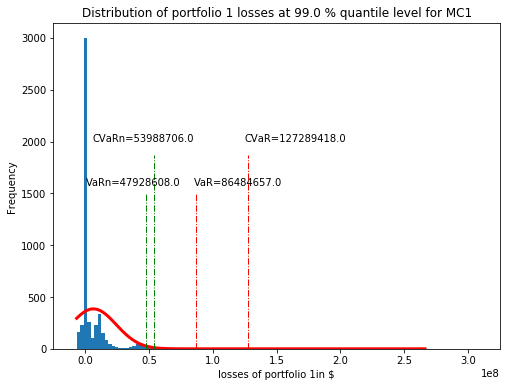

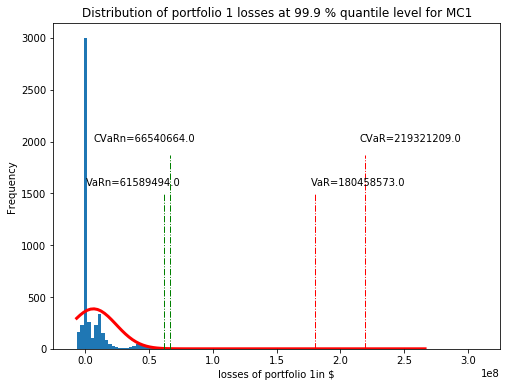

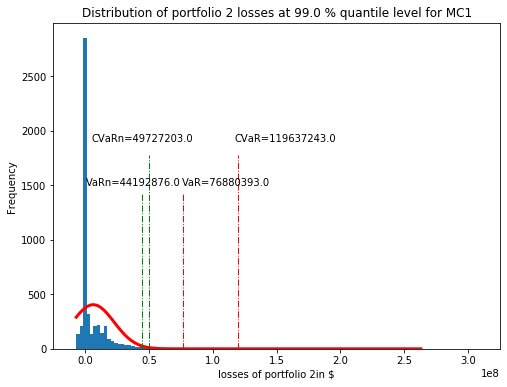

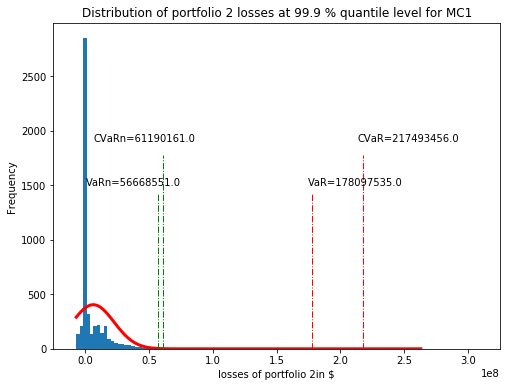

In [34]:
for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        p_losses_ = p_losses_MC1 = np.mean([item[:,portN] for item in portf_loss_inMC1_tr],axis=0)
        VAR = np.mean(VaRinMC1[portN, q])
        CVAR = np.mean(CVaRinMC1[portN, q])
        VARN = np.mean(VaRinN1[portN, q])
        CVARN = np.mean(CVaRinN1[portN, q])
        
        # Plot a histogram of the distribution of losses
        plt.figure(figsize=(8,6))
        frequencyCounts1, binLocations1, patches1 = plt.hist(p_losses_, 100)
        
        # Plotting the normal distribution approximation
        normf1 = (1 / (np.std(p_losses_) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations1.astype(float) - np.mean(p_losses_)) / np.std(p_losses_)) ** 2)
        normf1 = normf1 * sum(frequencyCounts1) / sum(normf1)
        plt.plot(binLocations1, normf1, color='r', linewidth=3.0)
        
        # Annotating the VAR,CVAR from original and normal approximation
        plt.plot([VARN, VARN], [0, max(frequencyCounts1) / 2], color='g', linewidth=1, linestyle='-.')
        plt.plot([VAR, VAR], [0, max(frequencyCounts1)/2], color='r', linewidth=1, linestyle='-.')
        plt.plot([CVAR, CVAR], [0, max(frequencyCounts1)/1.6], color='r', linewidth=1, linestyle='-.')
        plt.plot([CVARN, CVARN], [0, max(frequencyCounts1)/1.6], color='g', linewidth=1, linestyle='-.')
        
        plt.text(0.98 * VAR, max(frequencyCounts1) / 1.9, 'VaR='+str(np.round(VAR)))
        plt.text(0.98 * CVAR, max(frequencyCounts1) / 1.5, 'CVaR='+str(np.round(CVAR)))
        plt.text(0.005 * VARN, max(frequencyCounts1) / 1.9, 'VaRn='+str(np.round(VARN)))
        plt.text(0.1 * CVARN, max(frequencyCounts1) / 1.5, 'CVaRn='+str(np.round(CVARN)))
        
        # Labeling the axes and plot
        plt.title('Distribution of portfolio '+str(portN+1)+' losses at '+str(alf*100)+' % quantile level for MC1')
        plt.xlabel('losses of portfolio '+str(portN+1)+'in $')
        plt.ylabel('Frequency')
        plt.xlim(-0.25*10**8,3.25*10**8)
        plt.show()

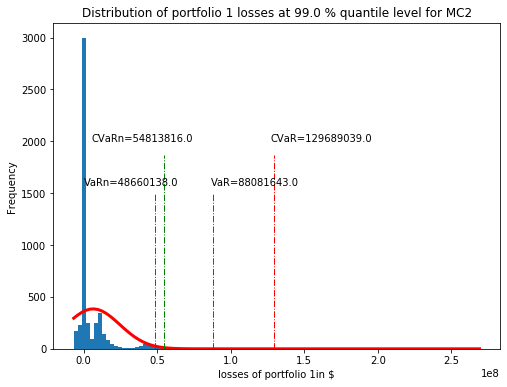

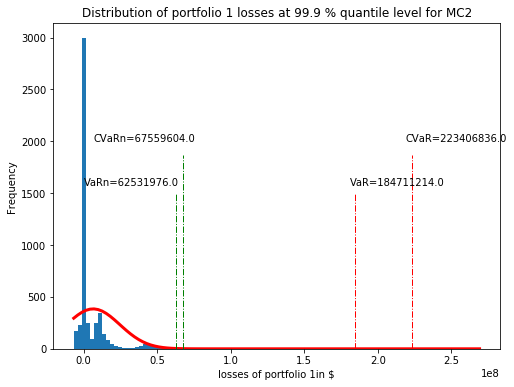

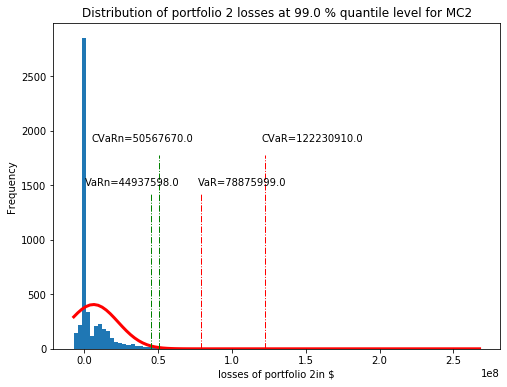

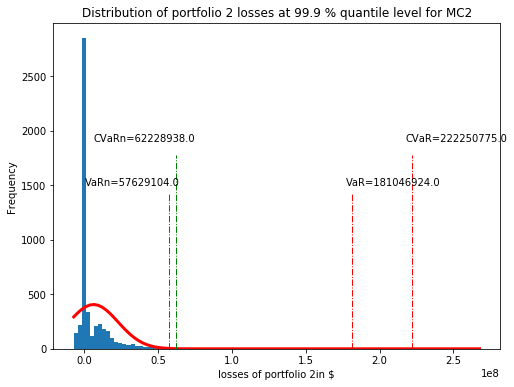

In [9]:
for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        p_losses_ = p_losses_MC2 = np.mean([item[:,portN] for item in portf_loss_inMC2_tr],axis=0)
        VAR = np.mean(VaRinMC2[portN, q])
        CVAR = np.mean(CVaRinMC2[portN, q])
        VARN = np.mean(VaRinN2[portN, q])
        CVARN = np.mean(CVaRinN2[portN, q])
        
        # Plot a histogram of the distribution of losses
        plt.figure(figsize=(8,6))
        frequencyCounts1, binLocations1, patches1 = plt.hist(p_losses_, 100)
        
        # Plotting the normal distribution approximation
        normf1 = (1 / (np.std(p_losses_) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations1.astype(float) - np.mean(p_losses_)) / np.std(p_losses_)) ** 2)
        normf1 = normf1 * sum(frequencyCounts1) / sum(normf1)
        plt.plot(binLocations1, normf1, color='r', linewidth=3.0)
        
        # Annotating the VAR,CVAR from original and normal approximation
        plt.plot([VARN, VARN], [0, max(frequencyCounts1) / 2], color='g', linewidth=1, linestyle='-.')
        plt.plot([VAR, VAR], [0, max(frequencyCounts1)/2], color='r', linewidth=1, linestyle='-.')
        plt.plot([CVAR, CVAR], [0, max(frequencyCounts1)/1.6], color='r', linewidth=1, linestyle='-.')
        plt.plot([CVARN, CVARN], [0, max(frequencyCounts1)/1.6], color='g', linewidth=1, linestyle='-.')
        plt.text(0.98 * VAR, max(frequencyCounts1) / 1.9, 'VaR='+str(np.round(VAR)))
        plt.text(0.98 * CVAR, max(frequencyCounts1) / 1.5, 'CVaR='+str(np.round(CVAR)))
        plt.text(0.005 * VARN, max(frequencyCounts1) / 1.9, 'VaRn='+str(np.round(VARN)))
        plt.text(0.1 * CVARN, max(frequencyCounts1) / 1.5, 'CVaRn='+str(np.round(CVARN)))
        
        # Labeling the axes and plot
        plt.title('Distribution of portfolio '+str(portN+1)+' losses at '+str(alf*100)+' % quantile level for MC2')
        plt.xlabel('losses of portfolio '+str(portN+1)+'in $')
        plt.ylabel('Frequency')
        plt.show()

### Analysis of sampling error

In [35]:
# Display VaR and CVaR
sampling_results = []
for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('\nAlpha {}:\n'.format(alf*100))
        print("====================================================================")
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        sampling_results.append([VaRout[portN, q],CVaRout[portN, q]])
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        sampling_results.append([np.mean(VaRinMC1[portN, q]),np.mean(CVaRinMC1[portN, q])])
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        sampling_results.append([np.mean(VaRinMC2[portN, q]),np.mean(CVaRinMC2[portN, q])])
        print("========================================================================")
        print('Sampling percentage error for MC1: VAR %4.1f%% =%6.2f, CVaR %4.1f%% =%6.2f' % (
        100 * alf,np.abs(VaRout[portN, q]-np.mean(VaRinMC1[portN, q]))/VaRout[portN, q]*100,
        100 * alf,np.abs(CVaRout[portN, q]-np.mean(CVaRinMC1[portN, q]))/CVaRout[portN, q]*100))
        print('Sampling percentage error for MC2: VAR %4.1f%% =%6.2f, CVaR %4.1f%% =%6.2f' % (
        100 * alf,np.abs(VaRout[portN, q]-np.mean(VaRinMC2[portN, q]))/VaRout[portN, q]*100,
        100 * alf,np.abs(CVaRout[portN, q]-np.mean(CVaRinMC2[portN, q]))/CVaRout[portN, q]*100))
        print("========================================================================")


Portfolio 1:


Alpha 99.0:

Out-of-sample: VaR 99.0% = $87527105.24, CVaR 99.0% = $127049344.94
In-sample MC1: VaR 99.0% = $86484657.27, CVaR 99.0% = $127289418.36
In-sample MC2: VaR 99.0% = $88081642.62, CVaR 99.0% = $129689038.92
Sampling percentage error for MC1: VAR 99.0% =  1.19, CVaR 99.0% =  0.19
Sampling percentage error for MC2: VAR 99.0% =  0.63, CVaR 99.0% =  2.08

Alpha 99.9:

Out-of-sample: VaR 99.9% = $188684264.10, CVaR 99.9% = $220286520.58
In-sample MC1: VaR 99.9% = $180458572.54, CVaR 99.9% = $219321208.65
In-sample MC2: VaR 99.9% = $184711213.71, CVaR 99.9% = $223406836.48
Sampling percentage error for MC1: VAR 99.9% =  4.36, CVaR 99.9% =  0.44
Sampling percentage error for MC2: VAR 99.9% =  2.11, CVaR 99.9% =  1.42

Portfolio 2:


Alpha 99.0:

Out-of-sample: VaR 99.0% = $77414612.81, CVaR 99.0% = $119493744.43
In-sample MC1: VaR 99.0% = $76880393.47, CVaR 99.0% = $119637243.34
In-sample MC2: VaR 99.0% = $78875998.77, CVaR 99.0% = $122230909.72
Sampling percentage e

### Analysis of Model error

In [39]:
# Display VaR and CVaR
sampling_results1 = []
for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('\nAlpha {}:\n'.format(alf*100))
        print("====================================================================")
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        sampling_results1.append([VaRout[portN, q],CVaRout[portN, q]])
        print('Out-of-sample N: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        sampling_results1.append([VaRinN[portN, q],CVaRinN[portN, q]])
        print("=====================================================================================")
        print('Model percentage error for Normal distribution: VAR %4.1f%% =%6.2f, CVaR %4.1f%% =%6.2f' % (
        100 * alf,np.abs(VaRout[portN, q]-VaRinN[portN, q])/VaRout[portN, q]*100,
        100 * alf,np.abs(CVaRout[portN, q]-CVaRinN[portN, q])/CVaRout[portN, q]*100))
        print("=====================================================================================")


Portfolio 1:


Alpha 99.0:

Out-of-sample: VaR 99.0% = $87527105.24, CVaR 99.0% = $127049344.94
Out-of-sample N: VaR 99.0% = $47942600.01, CVaR 99.0% = $53997664.12
Model percentage error for Normal distribution: VAR 99.0% = 45.23, CVaR 99.0% = 57.50

Alpha 99.9:

Out-of-sample: VaR 99.9% = $188684264.10, CVaR 99.9% = $220286520.58
Out-of-sample N: VaR 99.9% = $61592138.41, CVaR 99.9% = $66539196.65
Model percentage error for Normal distribution: VAR 99.9% = 67.36, CVaR 99.9% = 69.79

Portfolio 2:


Alpha 99.0:

Out-of-sample: VaR 99.0% = $77414612.81, CVaR 99.0% = $119493744.43
Out-of-sample N: VaR 99.0% = $44178300.17, CVaR 99.0% = $49704205.00
Model percentage error for Normal distribution: VAR 99.0% = 42.93, CVaR 99.0% = 58.40

Alpha 99.9:

Out-of-sample: VaR 99.9% = $181300705.46, CVaR 99.9% = $219995975.33
Out-of-sample N: VaR 99.9% = $56634989.12, CVaR 99.9% = $61149718.04
Model percentage error for Normal distribution: VAR 99.9% = 68.76, CVaR 99.9% = 72.20
